# App Rating Predictor
## Building an app rating predictor using data scraped from the android market
### We have scraped some apps from the Google PlayStore, and the primary goals of our project are:
- predict the rating
- predict installation count
- predict whether the app is free or paid 
- predict whether is it ad-supported

But before we start with the explanatory data analysis, we need to do data cleaning/preprocessing because our dataset is VERY UNSTRUCTURED and RAW.

# Table of contents
1. <a href='#model building'>Model Building</a>
2. <a href='#machine learning'>Machine Learning</a>

### Import packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
sb.set_theme(style="white", palette=None)
pd.set_option("display.max_columns", None) #Show all columns, or else some will just be "..."

import plotly.express as px # shows basic statistics of the figure
from dython import nominal # Use for calculating correlation between variables. Including between categorical and numerical variables
import matplotlib.pyplot as plt # we only need pyplot

import plotly.graph_objects as go # Used as trace for subplots
from plotly.subplots import make_subplots

In [2]:
df = pd.read_csv("./datasets/google_app_scrap_cleaned2.csv")
df.head()

,APP_NAME,RATING,CATEGORY,RATING_COUNT,1_STAR_RATINGS,2_STAR_RATINGS,3_STAR_RATINGS,4_STAR_RATINGS,5_STAR_RATINGS,REVIEW_COUNT,INSTALLS,MAX_INSTALLS,FREE,PRICE,SIZE,DEVELOPER,DEVELOPER_ADDRESS,COUNTRY,CONTENT_RATING,AD_SUPPORTED,IN_APP_PURCHASES,EDITORS_CHOICE,DAYS_SINCE_UPDATE,DAYS_SINCE_RELEASED,INSTALLS_GROUP,PRICEBAND,SIZEBAND
0,"""Ghost Voice Catcher"" AUTO EVP",3.933333,Lifestyle,68,12,1,6,7,42,24.0,"1,000+",3608,False,5.99,1100000.0,BIG BEARD Studios,114 1/2 Ash st. Nashua NH 03060,Usa,Everyone,False,False,False,1820.0,3482.0,Less than 100K,normal,small
1,"""OXXO""",4.740000,Game,975,23,0,15,94,843,54.0,"10,000+",21680,False,0.99,81000000.0,Hamster On Coke Games,ul Jugosłowiańska 37F/10\n73-110 Stargard Szcz...,NaN,Everyone,False,False,False,0.0,945.0,Less than 100K,cheap,medium
2,#DRIVE,4.434152,Game,229679,9352,4740,15249,47804,152534,6473.0,"5,000,000+",9119244,True,0.00,132000000.0,Pixel Perfect Dude S.A.,ul. Polna 28/6 lok. 4\n62-800 Kalisz\nPolska,NaN,Everyone,True,True,False,4.0,1084.0,Between 100K and 10M,Free,large
3,#SelfCare,4.463476,Game,14932,865,336,1088,1353,11290,1501.0,"1,000,000+",1209692,True,0.00,83000000.0,TRU LUV Inc.,"186-720 King Street West\nToronto, Ontario, Ca...",NaN,Teen,False,True,False,952.0,1275.0,Between 100K and 10M,Free,medium
4,#open Polyamorous + ENM Dating,2.550000,Dating,708,263,163,63,70,149,362.0,"50,000+",93463,True,0.00,19000000.0,#open,NaN,NaN,Mature 17+,False,True,False,17.0,1026.0,Less than 100K,Free,small


<a id='model building'></a>
## Model Building

First we identify the which features are usable in the dataset:
1. `RATING` (num)
2. `CATEGORY` (cat)
3. `INSTALLS_GROUP` (cat)
4. `SIZEBAND` (cat)
5. `FREE` (cat)
6. `PRICEBAND` (cat)
7. `AD_SUPPORTED` (cat)
8. `CONTENT_RATING` (cat)
9. `IN_APP_PURCHASES` (cat)
10. `EDITORS_CHOICE` (cat)


In [3]:
feature_list = ["RATING_COUNT", "RATING", "CATEGORY", "INSTALLS_GROUP", "SIZEBAND", "FREE", "PRICEBAND", "AD_SUPPORTED", "CONTENT_RATING", "IN_APP_PURCHASES", "EDITORS_CHOICE"]
model_df = df[feature_list].copy()
model_df.head()

,RATING_COUNT,RATING,CATEGORY,INSTALLS_GROUP,SIZEBAND,FREE,PRICEBAND,AD_SUPPORTED,CONTENT_RATING,IN_APP_PURCHASES,EDITORS_CHOICE
0,68,3.933333,Lifestyle,Less than 100K,small,False,normal,False,Everyone,False,False
1,975,4.740000,Game,Less than 100K,medium,False,cheap,False,Everyone,False,False
2,229679,4.434152,Game,Between 100K and 10M,large,True,Free,True,Everyone,True,False
3,14932,4.463476,Game,Between 100K and 10M,medium,True,Free,False,Teen,True,False
4,708,2.550000,Dating,Less than 100K,small,True,Free,False,Mature 17+,True,False


Handling null values

In [4]:
model_df.isna().sum()

RATING_COUNT        0
RATING              0
CATEGORY            0
INSTALLS_GROUP      0
SIZEBAND            0
FREE                0
PRICEBAND           0
AD_SUPPORTED        0
CONTENT_RATING      0
IN_APP_PURCHASES    0
EDITORS_CHOICE      0
dtype: int64

Seems like there are no null values in our dataset :)

In [5]:
model_df["INSTALLS_GROUP"].value_counts()

Between 100K and 10M    8498
Less than 100K          7939
More than 10M           1038
Name: INSTALLS_GROUP, dtype: int64

In [6]:
model_df["RATING_COUNT"].quantile(0.75) - model_df["RATING_COUNT"].quantile(0.25) 

55508.0

In [7]:
benchmark = 5000
model_df = model_df[model_df["RATING_COUNT"] > benchmark]
model_df.reset_index(inplace=True, drop=True)
model_df.shape

(9476, 11)

### Data Preprocessing

From eda, we noticed that RATING is skewed towards 4 and 5, so we categorize the rating into low (less than or equal to 3.5), medium (3.5 to 4.6) and high (greater than 4.6)

In [8]:
#Categorize
model_df.loc[model_df["RATING"] <=3.5 , "RATING_GROUP"] = "Low"
model_df.loc[(model_df["RATING"] >3.5) & (model_df["RATING"] <=4.6) , "RATING_GROUP"] = "Medium"
model_df.loc[model_df["RATING"] >4.6 , "RATING_GROUP"] = "High"
model_df.drop(["RATING"], axis = 1,inplace= True)
model_df["RATING_GROUP"].value_counts()

Medium    6757
High      2196
Low        523
Name: RATING_GROUP, dtype: int64

For `CATEGORY`, we noticed from eda that most apps falls under "Game" category, with that we change the category values to either "Game" or "Non Game"

In [9]:
model_df.loc[model_df["CATEGORY"] != "Game", "CATEGORY"] = "Non Game"
model_df["CATEGORY"].value_counts()

Non Game    5222
Game        4254
Name: CATEGORY, dtype: int64

For `CONTENT_RATING`, we just include Everyone, Teens and Adult

In [10]:
model_df['CONTENT_RATING'] = model_df['CONTENT_RATING'].replace('Mature 17+',"Adults")
model_df['CONTENT_RATING'] = model_df['CONTENT_RATING'].replace('Adults only 18+',"Adults")
model_df['CONTENT_RATING'] = model_df['CONTENT_RATING'].replace('Everyone 10+',"Everyone")
model_df["CONTENT_RATING"].value_counts()

Everyone    7118
Teen        1851
Adults       507
Name: CONTENT_RATING, dtype: int64

#### Handling categorical values

Before we continue, our categorical variables are further divided into 2 types —
- Ordinal categorical variables - `INSTALLS_GROUP`, `SIZEBAND`, `PRICEBAND`, `RATING_GROUP`,`FREE`, `AD_SUPPORTED`, `IN_APP_PURCHASES`, `EDITORS_CHOICE`
- Nominal categorical variable - `CATEGORY`,  `CONTENT_RATING`

In [11]:
nominal_cat = ["CONTENT_RATING", "CATEGORY"]
ordinal_cat = ["INSTALLS_GROUP", "SIZEBAND", "PRICEBAND", "RATING_GROUP","FREE","AD_SUPPORTED", "IN_APP_PURCHASES","EDITORS_CHOICE"]

**Handling Ordinal Categorical Variables**

In [12]:
ig_mapping = {"Less than 100K": 0, "Between 100K and 10M": 1, "More than 10M": 2}
pb_mapping = {"Free": 0, "cheap": 1, "normal": 2, "expensive": 3}
sb_mapping = {"small": 0, "medium": 1, "large": 2 }
rg_mapping = {"Low": 0, "Medium": 1, "High": 2}
free_mapping = {False: 0, True: 1}
ads_mapping = {False: 0, True: 1}
iap_mapping = {False: 0, True: 1}
ec_mapping = {False: 0, True: 1}
 
model_df["INSTALLS_GROUP"] = model_df["INSTALLS_GROUP"].map(ig_mapping)
model_df["PRICEBAND"] = model_df["PRICEBAND"].map(pb_mapping)
model_df["SIZEBAND"] = model_df["SIZEBAND"].map(sb_mapping)
model_df["RATING_GROUP"] = model_df["RATING_GROUP"].map(rg_mapping)
model_df["FREE"] = model_df["FREE"].map(free_mapping)
model_df["AD_SUPPORTED"] = model_df["AD_SUPPORTED"].map(ads_mapping)
model_df["IN_APP_PURCHASES"] = model_df["IN_APP_PURCHASES"].map(iap_mapping)
model_df["EDITORS_CHOICE"] = model_df["EDITORS_CHOICE"].map(ec_mapping)

model_df[["INSTALLS_GROUP", "PRICEBAND", "SIZEBAND", "RATING_GROUP","FREE","AD_SUPPORTED", "IN_APP_PURCHASES","EDITORS_CHOICE"]].head()

,INSTALLS_GROUP,PRICEBAND,SIZEBAND,RATING_GROUP,FREE,AD_SUPPORTED,IN_APP_PURCHASES,EDITORS_CHOICE
0,1,0,2,1,1,1,1,0
1,1,0,1,1,1,0,1,0
2,1,0,2,1,1,0,1,0
3,2,0,0,1,1,0,1,0
4,1,0,2,1,1,1,0,0


**Handling Nominal Categorical Variables**

In [13]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors 
model_df_cat = model_df[nominal_cat]
ohe.fit(model_df_cat)
model_df_cat_ohe = pd.DataFrame(ohe.transform(model_df_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(model_df_cat.columns))

# Check the encoded variables
model_df_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9476 entries, 0 to 9475
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CONTENT_RATING_Adults    9476 non-null   float64
 1   CONTENT_RATING_Everyone  9476 non-null   float64
 2   CONTENT_RATING_Teen      9476 non-null   float64
 3   CATEGORY_Game            9476 non-null   float64
 4   CATEGORY_Non Game        9476 non-null   float64
dtypes: float64(5)
memory usage: 370.3 KB


In [14]:
# Combine all features
model_df_ord = model_df[ordinal_cat]
model_df_encoded = pd.concat([ model_df_cat_ohe, model_df_ord], 
                           sort = False, axis = 1).reindex(index=model_df_ord.index)

# Check the final dataframe
model_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9476 entries, 0 to 9475
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CONTENT_RATING_Adults    9476 non-null   float64
 1   CONTENT_RATING_Everyone  9476 non-null   float64
 2   CONTENT_RATING_Teen      9476 non-null   float64
 3   CATEGORY_Game            9476 non-null   float64
 4   CATEGORY_Non Game        9476 non-null   float64
 5   INSTALLS_GROUP           9476 non-null   int64  
 6   SIZEBAND                 9476 non-null   int64  
 7   PRICEBAND                9476 non-null   int64  
 8   RATING_GROUP             9476 non-null   int64  
 9   FREE                     9476 non-null   int64  
 10  AD_SUPPORTED             9476 non-null   int64  
 11  IN_APP_PURCHASES         9476 non-null   int64  
 12  EDITORS_CHOICE           9476 non-null   int64  
dtypes: float64(5), int64(8)
memory usage: 962.5 KB


In [15]:
model_df_encoded.head()

,CONTENT_RATING_Adults,CONTENT_RATING_Everyone,CONTENT_RATING_Teen,CATEGORY_Game,CATEGORY_Non Game,INSTALLS_GROUP,SIZEBAND,PRICEBAND,RATING_GROUP,FREE,AD_SUPPORTED,IN_APP_PURCHASES,EDITORS_CHOICE
0,0.0,1.0,0.0,1.0,0.0,1,2,0,1,1,1,1,0
1,0.0,0.0,1.0,1.0,0.0,1,1,0,1,1,0,1,0
2,0.0,1.0,0.0,0.0,1.0,1,2,0,1,1,0,1,0
3,0.0,1.0,0.0,0.0,1.0,2,0,0,1,1,0,1,0
4,0.0,1.0,0.0,1.0,0.0,1,2,0,1,1,1,0,0


<a id='machine learning'></a>
## Machine learning
### Predict `RATING_GROUP`

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

**Creating a Model for RATING_GROUP: Attempt 1 (Naive Attempt)**

Since our data are mostly categorical variables, we chose Decision Tree as our model.

Our predictors for `RATING_GROUP`: `CONTENT_RATING`, `CATEGORY`, `INSTALLS_GROUP`, `SIZEBAND`, `PRICEBAND`, `FREE`, `AD_SUPPORTED`, `IN_APP_PURCHASES`, `EDITORS_CHOICE`

In [17]:
# Extract Response and Predictors
response = "RATING_GROUP"
y = pd.DataFrame(model_df_encoded[response])
X = pd.DataFrame(model_df_encoded.drop(response, axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=99)

#Fit the model
decision_tree = DecisionTreeClassifier() #set max-depth to default
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

Check the accuracy of the model

Train Data
              precision    recall  f1-score   support

           0       0.60      0.04      0.07       395
           1       0.73      0.98      0.83      5040
           2       0.61      0.10      0.18      1672

    accuracy                           0.72      7107
   macro avg       0.65      0.37      0.36      7107
weighted avg       0.69      0.72      0.64      7107


Train Data
              precision    recall  f1-score   support

           0       0.07      0.01      0.01       128
           1       0.73      0.96      0.83      1717
           2       0.41      0.08      0.13       524

    accuracy                           0.72      2369
   macro avg       0.41      0.35      0.33      2369
weighted avg       0.63      0.72      0.63      2369



<AxesSubplot:>

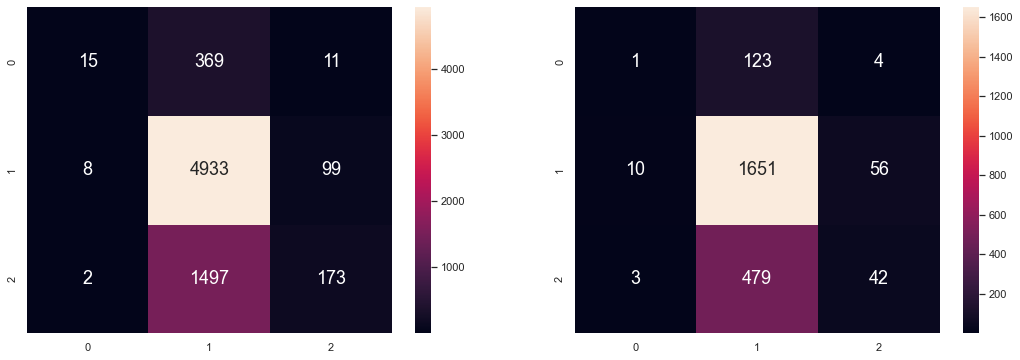

In [18]:
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

# Print the Classification Report
print("Train Data")
print(classification_report(y_train,y_train_pred))
print()

print("Train Data")
print(classification_report(y_test,y_test_pred))

# Plot the three-way Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])

**Creating a Model for RATING_GROUP: Attempt 2 (GridSearchCV)**

Here we try to use many decision trees to predict `RATING_GROUP` in which we are going to use the Random Forest model. At the same time, we are using Cross-Validation to find the best Hyper-parameters of this random forest model. 

In [19]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Extract Response and Predictors
response = "RATING_GROUP"
y = pd.DataFrame(model_df_encoded[response])
X = pd.DataFrame(model_df_encoded.drop(response, axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=99)

In [20]:
rfc= RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [1, 100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10,12,14,16],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12, 14, 16],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 100, 500, 1000]})

max_depth = np.arange(10,20)

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeClassifier(max_depth=12), X, y, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

In [21]:
from sklearn.ensemble import RandomForestClassifier

#fit
model_rf = RandomForestClassifier(criterion='entropy')
model_rf.fit(X_train, y_train)

#predict y
y_pred_test_rf = model_rf.predict(X_test)

#score
print(confusion_matrix(y_test, y_pred_test_rf))

[[   0  124    4]
 [   2 1650   65]
 [   1  477   46]]


In [22]:
# Fetch the best Model or the best set of Hyper-parameters
print(CV_rfc.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(CV_rfc.best_score_))

RandomForestClassifier(max_depth=4, random_state=42)
0.7091600673442664


Train Data
              precision    recall  f1-score   support

           0       0.60      0.04      0.07       395
           1       0.73      0.98      0.83      5040
           2       0.61      0.10      0.18      1672

    accuracy                           0.72      7107
   macro avg       0.65      0.37      0.36      7107
weighted avg       0.69      0.72      0.64      7107


Train Data
              precision    recall  f1-score   support

           0       0.07      0.01      0.01       128
           1       0.73      0.96      0.83      1717
           2       0.41      0.08      0.13       524

    accuracy                           0.72      2369
   macro avg       0.41      0.35      0.33      2369
weighted avg       0.63      0.72      0.63      2369



<AxesSubplot:>

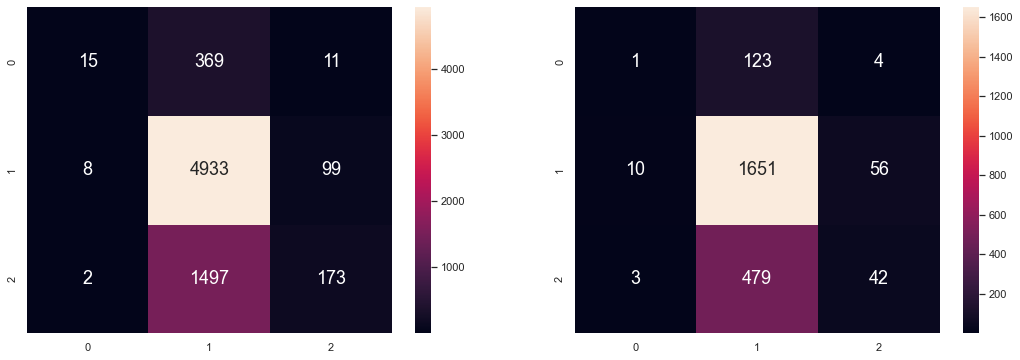

In [23]:
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

# Print the Classification Report
print("Train Data")
print(classification_report(y_train,y_train_pred))
print()

print("Train Data")
print(classification_report(y_test,y_test_pred))

# Plot the three-way Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])

In [24]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

72.06

In [25]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.07      0.01      0.01       128
           1       0.73      0.96      0.83      1717
           2       0.41      0.08      0.13       524

    accuracy                           0.72      2369
   macro avg       0.41      0.35      0.33      2369
weighted avg       0.63      0.72      0.63      2369

[[   1  123    4]
 [  10 1651   56]
 [   3  479   42]]


### Predict `INSTALLS_GROUP`

In [26]:
# Extract Response and Predictors
response = "INSTALLS_GROUP"
y = pd.DataFrame(model_df_encoded[response])
X = pd.DataFrame(model_df_encoded.drop(response, axis = 1))
X.drop(["RATING_GROUP"], inplace = True, axis = 1)

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=99)

#Fit the model
decision_tree = DecisionTreeClassifier() #set max-depth to default
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

Train Data
              precision    recall  f1-score   support

           0       0.77      0.49      0.59       723
           1       0.83      0.98      0.90      5616
           2       0.74      0.04      0.08       768

    accuracy                           0.83      7107
   macro avg       0.78      0.50      0.52      7107
weighted avg       0.82      0.83      0.78      7107


Train Data
              precision    recall  f1-score   support

           0       0.72      0.47      0.57       248
           1       0.82      0.97      0.89      1852
           2       0.57      0.04      0.08       269

    accuracy                           0.81      2369
   macro avg       0.70      0.49      0.51      2369
weighted avg       0.78      0.81      0.76      2369



<AxesSubplot:>

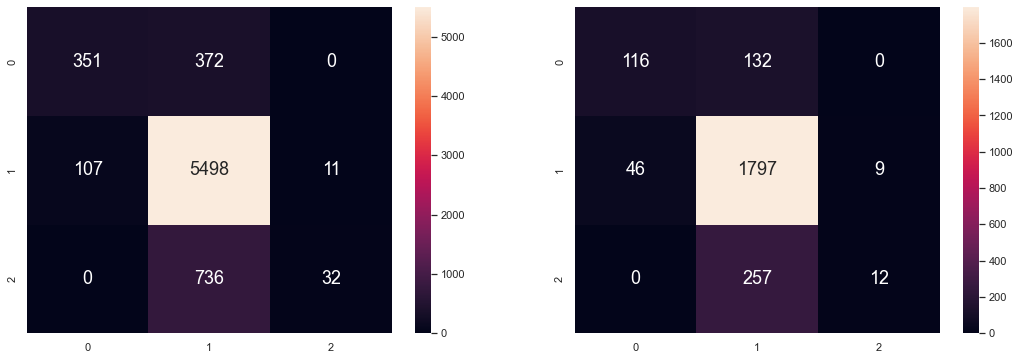

In [27]:
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

# Print the Classification Report
print("Train Data")
print(classification_report(y_train,y_train_pred))
print()

print("Train Data")
print(classification_report(y_test,y_test_pred))

# Plot the three-way Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])

In [28]:
decision_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [29]:
rfc= RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [1, 100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10,12,14,16],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12, 14, 16],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 100, 500, 1000]})

In [30]:
# Fetch the best Model or the best set of Hyper-parameters
print(CV_rfc.best_params_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(CV_rfc.best_score_))

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
0.8228501352527043


Train Data
              precision    recall  f1-score   support

           0       0.76      0.49      0.59       723
           1       0.83      0.98      0.90      5616
           2       0.73      0.04      0.08       768

    accuracy                           0.83      7107
   macro avg       0.78      0.50      0.53      7107
weighted avg       0.81      0.83      0.78      7107


Train Data
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       248
           1       0.82      0.97      0.89      1852
           2       0.57      0.04      0.08       269

    accuracy                           0.81      2369
   macro avg       0.71      0.50      0.52      2369
weighted avg       0.78      0.81      0.77      2369



<AxesSubplot:>

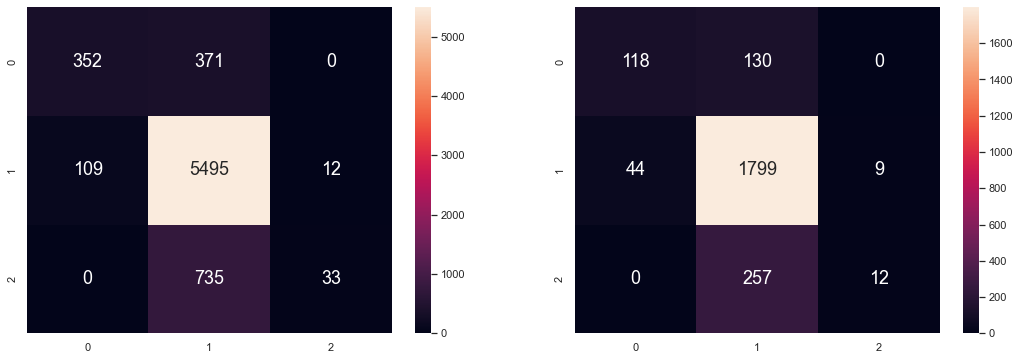

In [31]:
#Fit the model
rfc_best = RandomForestClassifier(criterion="gini", max_depth=8, max_features="auto", n_estimators=100) 
rfc_best.fit(X_train, y_train)

y_train_pred = rfc_best.predict(X_train)
y_test_pred = rfc_best.predict(X_test)

# Print the Classification Report
print("Train Data")
print(classification_report(y_train,y_train_pred))
print()

print("Train Data")
print(classification_report(y_test,y_test_pred))

# Plot the three-way Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])